# DATA

In [1]:
%load_ext autoreload
%autoreload 2
import genericIO
import SepVector
import Hypercube
import numpy as np
import Operator
import time

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.9/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [30]:
n1 = 100
n2 = 100 
n3 = 44

d1 = 0.02
d2 = 0.01
d3 = 1

o1 = 0
o2 = 0
o3 = 1

slow3d = SepVector.getSepVector(Hypercube.hypercube(ns=[n1,n2,n3],ds=[d1,d2,d3],os=[o1,o2,o3]),storage='dataComplex')
slow2d = SepVector.getSepVector(Hypercube.hypercube(ns=[n1,n2],ds=[d1,d2],os=[o1,o2]),storage='dataComplex')
den2d = slow2d.clone()
den2d.set(1)
den3d = slow3d.clone()
den3d.set(1)

true = 2
bg = 1

slowNd = slow3d.getNdArray()
slowNd[:].real = 1/true**2
slowNd[:,int(1.5*n2/2)::,:].real = 1/3*1/3
# den2d[int(1.5*n2/2)::,:] = 2

slow2dNd = slow2d.getNdArray()
slow2dNd[:] = slowNd[0,:,:]

In [31]:
import newExtWEM 
import json

par = {
    "ns" : 21,
    "dsx" : .1,
    "osx" : 0,
    "dsz" : 0,
    "osz" : .05,
    
    "nr" : 100,
    "drx" : d1,
    "orx" : 0,
    "drz" : 0,
    "orz" : 0,
    "onepass" : 0,
    
    "fmax" : 15,
    "fmin" : 1,   
    
    "nref" : 1,
    "tap" : 100,
    "pad" : 100,
    "tpad" : 0,
    "ngs" : 3,
    "ngr" : 3,
    "prop" : 'ssf',
    
    "ntaylor" : 1,
    "eps" : 0.01
    
}


ot = 0
tmax = 3
dt = 0.004
nt = int((tmax-ot) / dt)
wave = SepVector.getSepVector(Hypercube.hypercube(ns=[nt],ds=[dt],os=[ot]))
waveNd = wave.getNdArray()
t = np.linspace(ot,tmax,nt) - .5
f0 = 5
waveNd[:] = (1-2*(np.pi*f0*t)**2)* np.exp(-(np.pi*f0*t)**2)
print(waveNd.shape)

data = SepVector.getSepVector(ns=[nt,par["nr"],par["ns"]],
                                  ds=[dt,par["drx"],par["dsx"]],
                                  os=[ot,par["orx"],par["osx"]])

parObj = genericIO.pythonParams(par)

(750,)


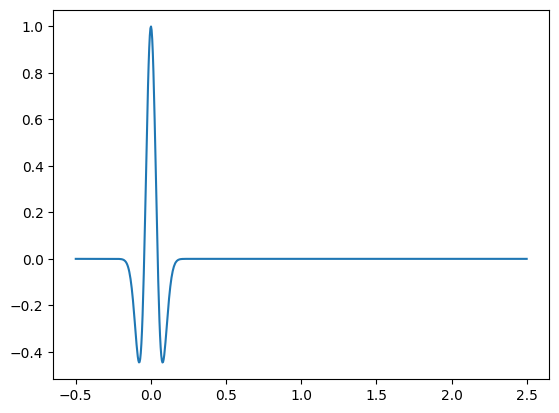

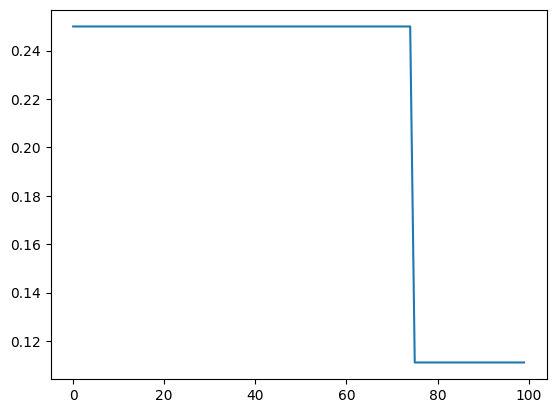

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t,waveNd)

plt.figure()
plt.plot(slow2dNd[:,0])

In [19]:
from pyVector import superVector

model2d = superVector(slow2d, den2d)

In [20]:
import WEM
wem = WEM.WEM(model2d,data,wave,parObj)
wem.forward(False,model2d,data)

fmin = 1; fmax = 15.3525
nfreq = 44; from imin = 2 to imax = 45
nshots = 21; nrec = 100
Propagating shots ... 
47.2386 s


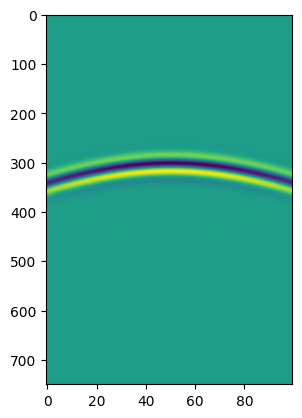

In [21]:
plt.imshow(data[10,:,:].T, aspect=.2)

In [22]:
image = model2d.clone()
born = WEM.Born(model2d,data,wave,parObj)

fmin = 1; fmax = 15.3525
nfreq = 44; from imin = 2 to imax = 45
nshots = 21; nrec = 100


In [23]:
born.adjoint(False,image,data)

Adjoint born ... 
131.707 s


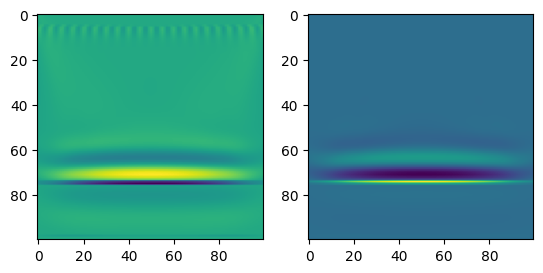

In [25]:
fig, ax = plt.subplots(1,2)

ax[0].imshow(image.vecs[0].getNdArray().real)
ax[1].imshow(image.vecs[1].getNdArray().real)

# Extended Born

In [26]:
model.vecs[0][:] = 1/bg**2
model.vecs[1][:] = bg
fm = data.clone()
wem.forward(False,model,fm)
fm.scaleAdd(data,1,-1)

Propagating shots ... 
24.3876 s


floatVector
Axis 1: n=750	o=0.000000	d=0.004000
Axis 2: n=100	o=0.000000	d=0.020000
Axis 3: n=21	o=0.000000	d=0.100000

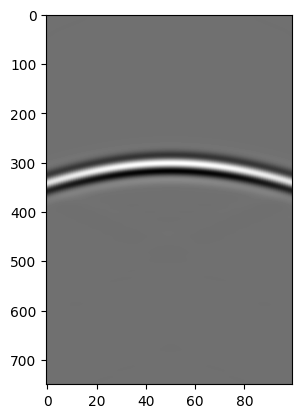

In [27]:
plt.imshow(fm.getNdArray()[10,:,:].T,aspect=.2, cmap='gray')
# plt.savefig('ex_res.png', dpi=300)

In [11]:
# scaleOp = Operator.ScaleOffset(fm, fm, par, scale=1e12)
# fm_scaled = fm.clone()
# scaleOp.forward(False, fm, fm_scaled)

In [43]:
import newExtWEM
slow3d[:] = 1/bg**2
model3d = superVector(slow3d, den3d)

bornExt = newExtWEM.extBorn(model3d,data,wave,parObj)
# bornExt = Op.ChainOperator(bornExt,data)
image3d = model3d.clone()
bornExt.adjoint(False,image3d,fm)

fmin = 1; fmax = 15.3525
nfreq = 44; from imin = 2 to imax = 45
nshots = 21; nrec = 100
Adjoint born ... 
211.084 s


(44, 100, 100)


Text(0, 0.5, 'Depth [samples]')

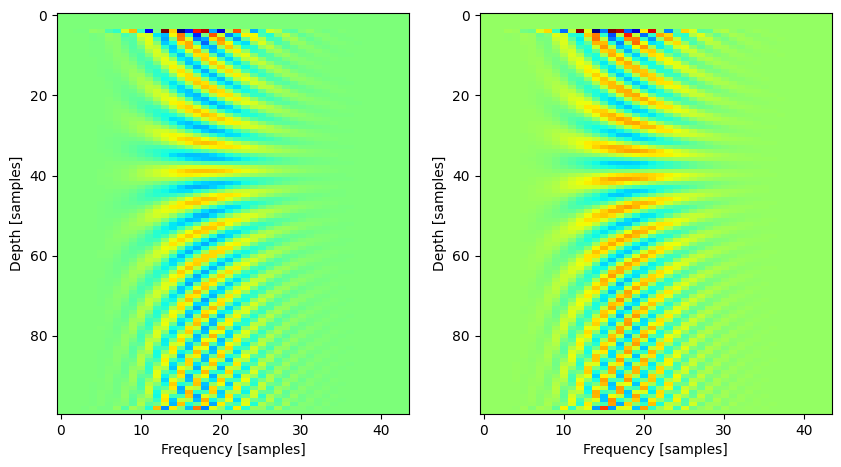

In [44]:
%matplotlib inline
im3d = image3d.vecs[0].getNdArray()
print(im3d.shape)

fig, ax = plt.subplots(1,2,figsize=[10,10])

ax[0].imshow(im3d[:,:,50].T.real,aspect=.5,cmap='jet')
ax[0].set_xlabel('Frequency [samples]')
ax[0].set_ylabel('Depth [samples]')

ax[1].imshow(im3d[:,:,50].T.imag,aspect=.5,cmap='jet')
ax[1].set_xlabel('Frequency [samples]')
ax[1].set_ylabel('Depth [samples]')

# plt.savefig('ex_ext_image.png', dpi=300)

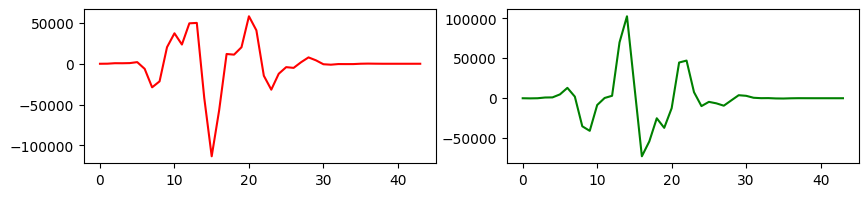

In [14]:
%matplotlib inline

fig, ax = plt.subplots(1,2,figsize=[10,2])
ax[0].plot(im3d[:,50,50].real,'red')
ax[1].plot(im3d[:,50,50].imag,'green')

# plt.savefig('ex_ext_image_slice.png', dpi=300)

# Frequency-to-time image

(750, 100, 100)


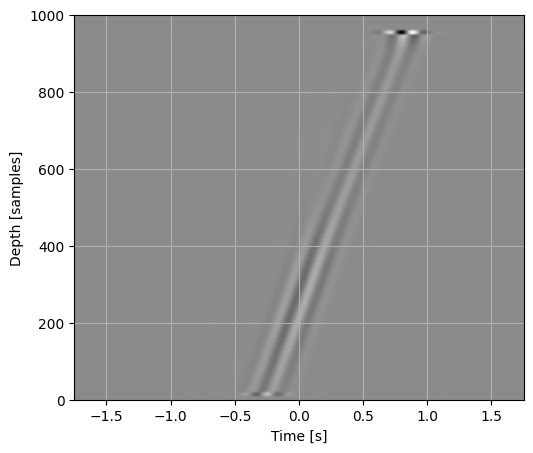

In [42]:
import numpy as np
f0 = par["fmin"]
df = 1/(tmax + 0.5 + par["tpad"]*dt)
im3d_time = np.zeros((nt+par["tpad"],im3d.shape[1],im3d.shape[2]),dtype=complex)
im3d_time[int(f0/df):n3+int(f0/df),:,:] = im3d[:]
im3d_time = np.fft.ifft(im3d_time,axis=0)
print(im3d_time.shape)
mat = np.fft.fftshift(im3d_time[:,:,50].T.real,axes=1)

plt.figure(figsize=[10,5])
plt.imshow(mat,cmap='gray',aspect=.003,extent=[-(tmax+0.5+ par["tpad"]*dt)/2,(tmax+.5+ par["tpad"]*dt)/2,0,1000])
plt.xlabel('Time [s]')
plt.ylabel('Depth [samples]')
plt.grid()

# plt.savefig('ex_ext_image_time.png', dpi=300)

In [16]:
softclip = Operator.Softclip(image3d, image3d, l=1, tau=1e-9)
temp = image3d.clone()
softclip.forward(False, image3d, temp)

# L\*B\*d

In [45]:
import pyOperator as Op
import Operator
n1new = 100
d1new = (n1-1)*d1 / (n1new - 1)
n2new = 100
d2new = (n2-1)*d2 / (n2new - 1)
n3new = 9
d3new = (n3-1)*d3 / max(1,(n3new - 1))

smol3d = SepVector.getSepVector(Hypercube.hypercube(ns=[n1new,n2new,n3new],ds=[d1new,d2new,d3new],os=[o1,o2,o3]),storage='dataComplex')
model_smol3d = superVector(smol3d, den3d)

lanc1 = Operator.Spline3D(smol3d,slow3d,type='CR-spline',taper=[0,0,0])
lanc2 = Operator.Spline3D(slow3d,slow3d,type='CR-spline',taper=[0,0,0])
lanc = Op.Dstack(lanc1, lanc2)

# chain = Op.ChainOperator(lanc,bornExt)
im_smol3d = model_smol3d.clone()
# chain.adjoint(False,im_smol3d,data)

Text(0.5, 1.0, 'interp imag')

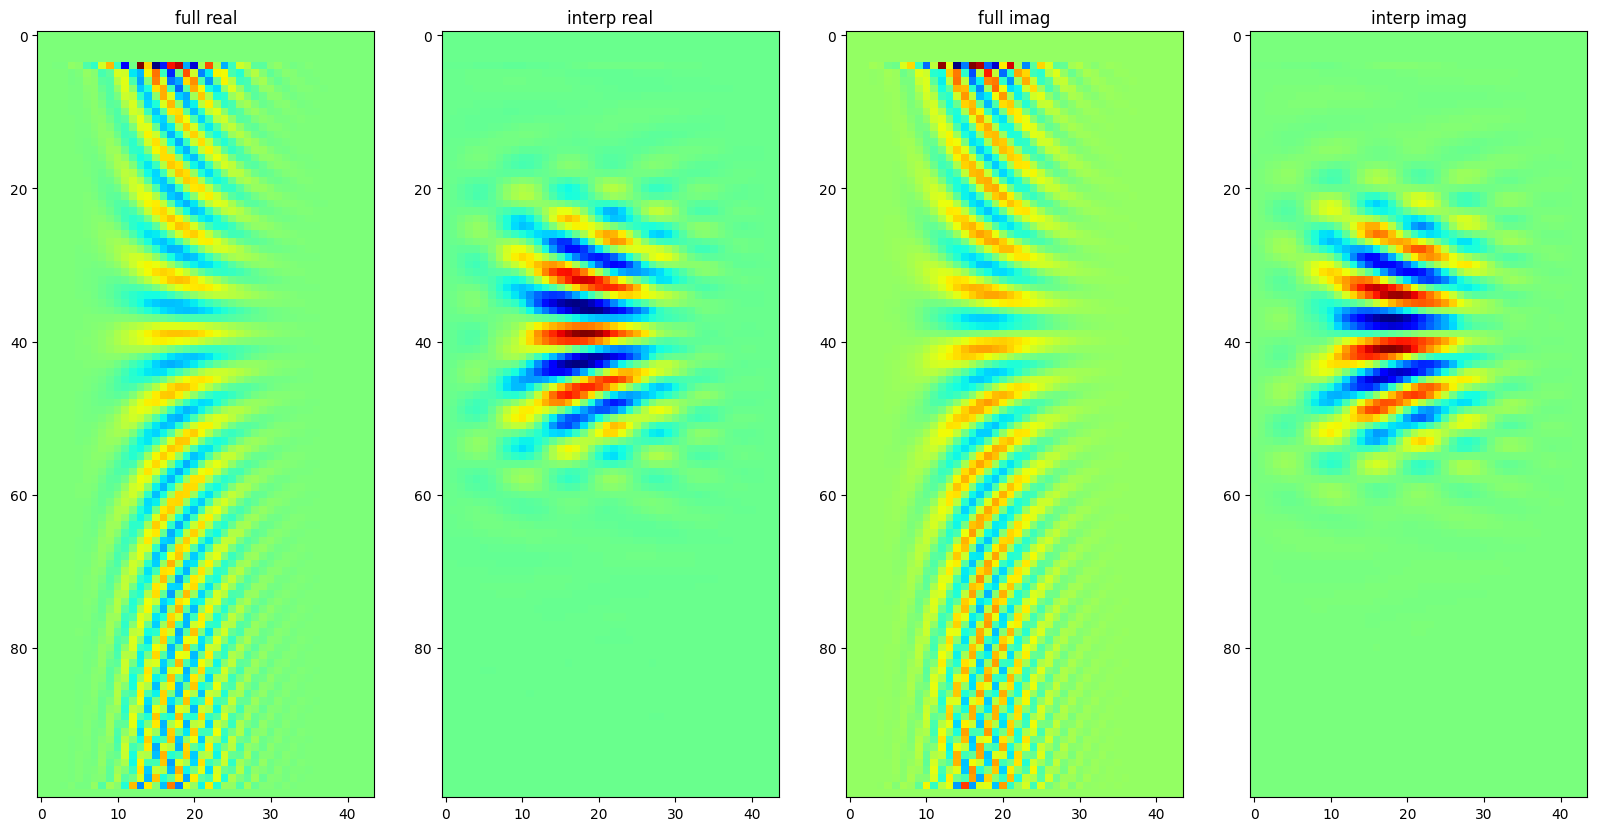

In [52]:
%matplotlib inline

im_smol_int = image3d.clone()
lanc.adjoint(False,im_smol3d,image3d)
lanc.forward(False,im_smol3d,im_smol_int)
imsmint = im_smol_int.vecs[0].getNdArray()

fig,ax = plt.subplots(1,4,figsize=[20,10])
ax[0].imshow(im3d[:,:,50].T.real,cmap='jet')
ax[0].set_title('full real')
ax[1].imshow(imsmint[:,:,50].T.real,cmap='jet')
ax[1].set_title('interp real')
ax[2].imshow(im3d[:,:,50].T.imag,cmap='jet')
ax[2].set_title('full imag')
ax[3].imshow(imsmint[:,:,50].T.imag,cmap='jet')
ax[3].set_title('interp imag')
# plt.show()
# plt.savefig('ex_interpolated.png', dpi=300)

# Check windowing prop of Lanczos

In [50]:
import numpy as np

smol3d_time = np.zeros((nt+par["tpad"],im3d.shape[1],im3d.shape[2]),dtype=complex)
smol3d_time[int(f0/df):n3+int(f0/df),:,:] = imsmint[:]
smol3d_time = np.fft.ifft(smol3d_time,axis=0)

mat2 = np.fft.fftshift(smol3d_time[:,:,50].T.real,axes=1)

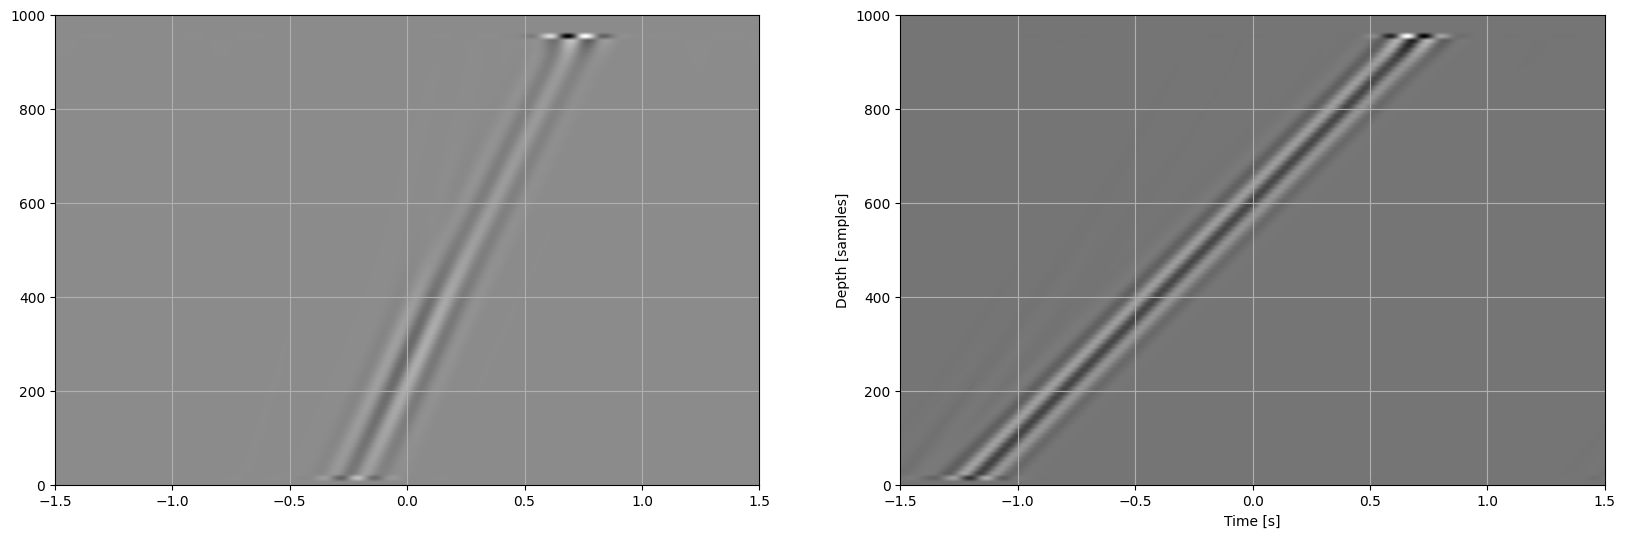

In [51]:
fig,ax = plt.subplots(1,2, figsize=[20,10])

ax[0].imshow(mat,cmap='gray',aspect=.002,extent=[-tmax/2,tmax/2,0,1000])
plt.xlabel('Time [s]')
plt.ylabel('Depth [samples]')
ax[1].imshow(mat2,cmap='gray',aspect=.002,extent=[-tmax/2,tmax/2,0,1000])
plt.xlabel('Time [s]')
plt.ylabel('Depth [samples]')
ax[0].grid() 
ax[1].grid()

# plt.show()

plt.savefig('ex_windowed_image.png', dpi=300)

In [21]:
image3d_der = smol3d.clone()
im3d_der = image3d_der.getNdArray()
tm = (tmax+.5+ par["tpad"]*dt)/2
tm = .5

der = Operator.Derivative(smol3d,smol3d,which=1,
                          order=8,f0=par["fmin"],tmax=tm,dt=dt,alpha=0,beta=1)
der.forward(False,im_smol3d,image3d_der)

750


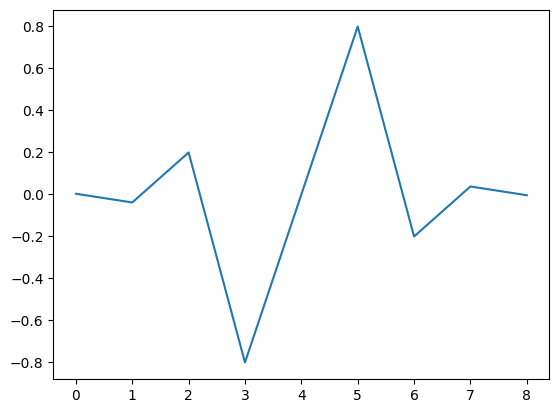

In [22]:
print(nt)
plt.plot(der.filter[:])

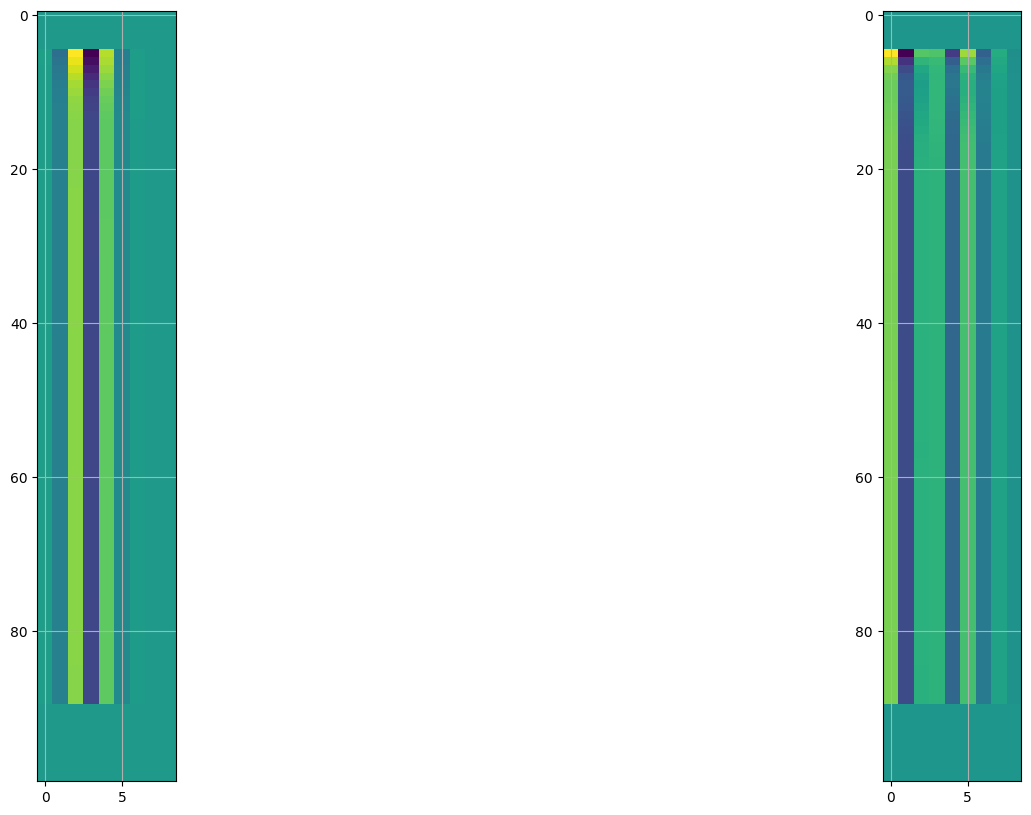

In [23]:
fig, ax = plt.subplots(1,2,figsize=[20,10])
ax[0].imshow(im_smol3d.getNdArray()[:,:,50].T.real,aspect=.5)
ax[1].imshow(im3d_der[:,:,50].T.real,aspect=.5)
ax[0].grid(); ax[1].grid()


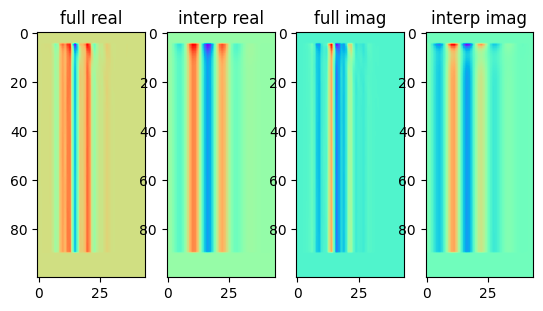

In [24]:
%matplotlib inline

im_smol_int = image3d.clone()
lanc.adjoint(False,im_smol3d,image3d)
lanc.forward(False,im_smol3d,im_smol_int)
imsmint = im_smol_int.getNdArray()

fig,ax = plt.subplots(1,4)
ax[0].imshow(im3d[:,:,50].T.real,cmap='rainbow')
ax[0].set_title('full real')
ax[1].imshow(imsmint[:,:,50].T.real,cmap='rainbow')
ax[1].set_title('interp real')
ax[2].imshow(im3d[:,:,50].T.imag,cmap='rainbow')
ax[2].set_title('full imag')
ax[3].imshow(imsmint[:,:,50].T.imag,cmap='rainbow')
ax[3].set_title('interp imag')
plt.show()

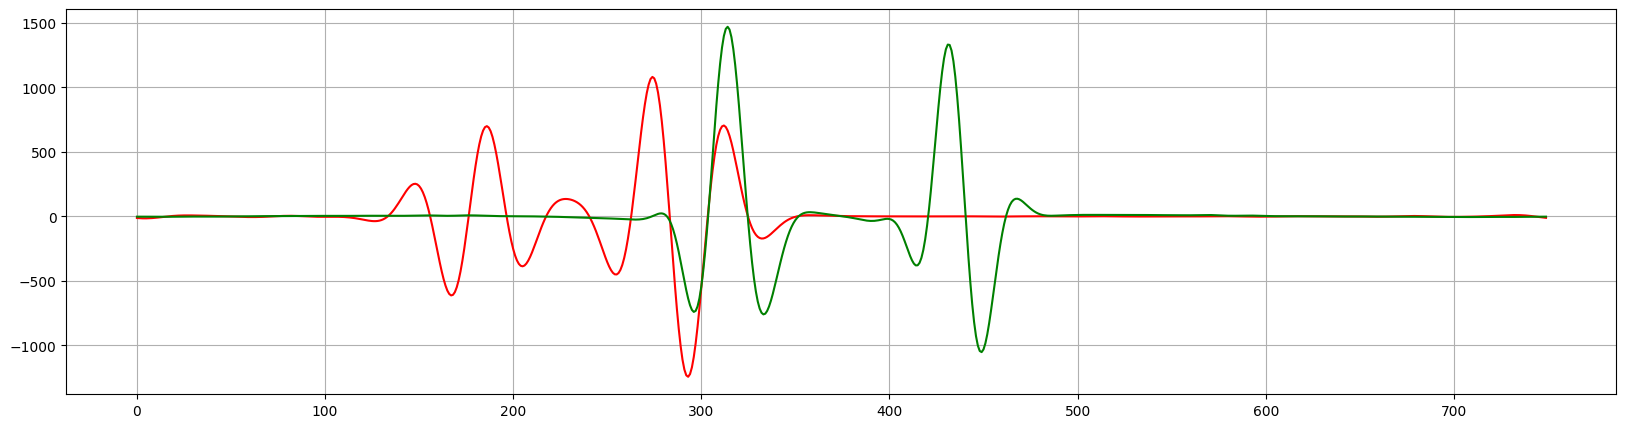

In [25]:
%matplotlib inline
fig = plt.figure(figsize=[20,5])
plt.plot(mat.T[:,50],color='red')
plt.plot(mat2.T[:,50],color='green')
plt.grid()
plt.show()

In [26]:
%matplotlib inline

der.forward(False,im_smol_int,image3d_der)
der.adjoint(False,image3d_der2,image3d_der)

im3d_der2_time = np.zeros((nt,im3d.shape[1],im3d.shape[2]),dtype=complex)
im3d_der2_time[int(f0/df):n3+int(f0/df),:,:] = im3d_der2[:]
im3d_der2_time = np.fft.ifft(im3d_der2_time,axis=0)
mat_der2 = np.fft.fftshift(im3d_der2_time[:,:,50].T.real,axes=1)

fig, ax = plt.subplots(1,2,figsize=[20,10])
ax[0].imshow(mat,cmap='gray',aspect=.002,extent=[-tmax/2,tmax/2,0,1000])
ax[1].imshow(mat_der2,cmap='gray',aspect=.002,extent=[-tmax/2,tmax/2,0,1000])
ax[0].grid()
ax[1].grid()

ValueError: operands could not be broadcast together with shapes (9,100,100) (44,100,100) (9,100,100) 

## Spline

In [ ]:
import pyOperator as Op
import Operator
n1new = 100
d1new = (n1-1)*d1 / (n1new - 1)
n2new = 100
d2new = (n2-1)*d2 / (n2new - 1)
n3new = 31
d3new = (n3-1)*d3 / (n3new - 1)

spline = Operator.Spline3D(smol3d,slowL,type="CR-spline",taper=[0.,0.,0.9])

# chain = Op.ChainOperator(spline,bornExt)
# chain.adjoint(False,im_smol3d,data)

In [ ]:
%matplotlib inline

spline.adjoint(False,im_smol3d,image3d)
spline.forward(False,im_smol3d,im_smol_int)

fig,ax = plt.subplots(1,4)
ax[0].imshow(im3d[:,:,50].T.real,cmap='rainbow')
ax[0].set_title('full real')
ax[1].imshow(imsmint[:,:,50].T.real,cmap='rainbow')
ax[1].set_title('interp real')
ax[2].imshow(im3d[:,:,50].T.imag,cmap='rainbow')
ax[2].set_title('full imag')
ax[3].imshow(imsmint[:,:,50].T.imag,cmap='rainbow')
ax[3].set_title('interp imag')
plt.show()

In [ ]:
import numpy as np
smol3d_time[:n3,:,:] = imsmint[:]
smol3d_time = np.fft.ifft(smol3d_time,axis=0)
mat2 = np.fft.fftshift(smol3d_time[:,:,50].T.real,axes=1)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=[20,10])
fig.set_size_inches([20,20])
ax[0].imshow(mat,cmap='gray',aspect=.002,extent=[-tmax/2,tmax/2,0,1000])
ax[1].imshow(mat2,cmap='gray',aspect=.002,extent=[-tmax/2,tmax/2,0,1000])
ax[0].grid(); ax[1].grid()
plt.show()

In [ ]:
%matplotlib inline

der.forward(False,im_smol_int,image3d_der)
der.adjoint(False,image3d_der2,image3d_der)

im3d_der2_time = np.zeros((nt,im3d.shape[1],im3d.shape[2]),dtype=complex)
im3d_der2_time[int(f0/df):n3+int(f0/df),:,:] = im3d_der2[:]
im3d_der2_time = np.fft.ifft(im3d_der2_time,axis=0)
mat_der2 = np.fft.fftshift(im3d_der2_time[:,:,50].T.real,axes=1)

fig, ax = plt.subplots(1,2,figsize=[20,10])
ax[0].imshow(mat,cmap='gray',aspect=.002,extent=[-tmax/2,tmax/2,0,1000])
ax[1].imshow(mat_der2,cmap='gray',aspect=.002,extent=[-tmax/2,tmax/2,0,1000])
ax[0].grid()
ax[1].grid()

In [27]:
big = SepVector.getSepVector(ns=[n1, n2, 2*n3], os=[o1, o2, o3], ds=[d1, d2, d3/2], storage='dataComplex')

In [28]:
L = Operator.LanczosInterpolation3D(image3d, big, a=[1,1,3], taper=[0,0,0])
L.forward(False, image3d, big)

In [29]:
big.set(0)

complexVector
Axis 1: n=100	o=0.000000	d=20.000000
Axis 2: n=100	o=0.000000	d=10.000000
Axis 3: n=88	o=1.000000	d=0.500000

In [30]:
big[:image3d.shape[0],:,:] = image3d[:,:,:]

TypeError: 'complexVector' object is not subscriptable

In [ ]:
res = image3d.clone()
L.adjoint(False, res, big)

In [ ]:
fig,ax = plt.subplots(1,4,figsize=[20,10])
ax[0].imshow(image3d[:,:,50].T.real,cmap='jet')
ax[0].set_title('full real')
ax[1].imshow(big[:,:,50].T.real,cmap='jet')
ax[1].set_title('interp real')
ax[2].imshow(res[:,:,50].T.imag,cmap='jet')
ax[2].set_title('full imag')
# ax[3].imshow(imsmint[:,:,50].T.imag,cmap='jet')
# ax[3].set_title('interp imag')
# # plt.show()
# plt.savefig('ex_interpolated.png', dpi=300)

In [ ]:
plt.plot(res[:,50,50])
plt.plot(image3d[:,50,50], color='red')